# Capacity allocation

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import itertools
import numpy as np
import pyomo.environ as pyo
import shutil

from benchmarks.generator import get_revenue_behavior_deprecated
from benchmarks.utils import int_input, get_schedule_from_supply, infer_line_stations, \
    get_services_by_tsp_df, plot_marey_chart, SAFETY_GAP
from src.entities import Solution
from src.timetabling_problem import MPTT

from math import e, pi
from pathlib import Path
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Supply
from robin.supply.generator.entities import ServiceScheduler
from robin.supply.saver.entities import SupplySaver

In [2]:
# Config files
supply_config_path = Path('../configs/generator/supply_config.yml')
demand_config_path = Path('../configs/demand/demand.yml')
generator_config_path = Path('../configs/generator/generator_config.yml')

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input('Number of services to generate: ')
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(output_path=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

     Number of Services
RU2                   3
RU3                   7
RU1                   5
RU4                   5
RU5                   5


In [5]:
print('Services: ', len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behavior = get_revenue_behavior_deprecated(supply)
lines = list(supply.lines)
line = infer_line_stations(lines)

Services:  25


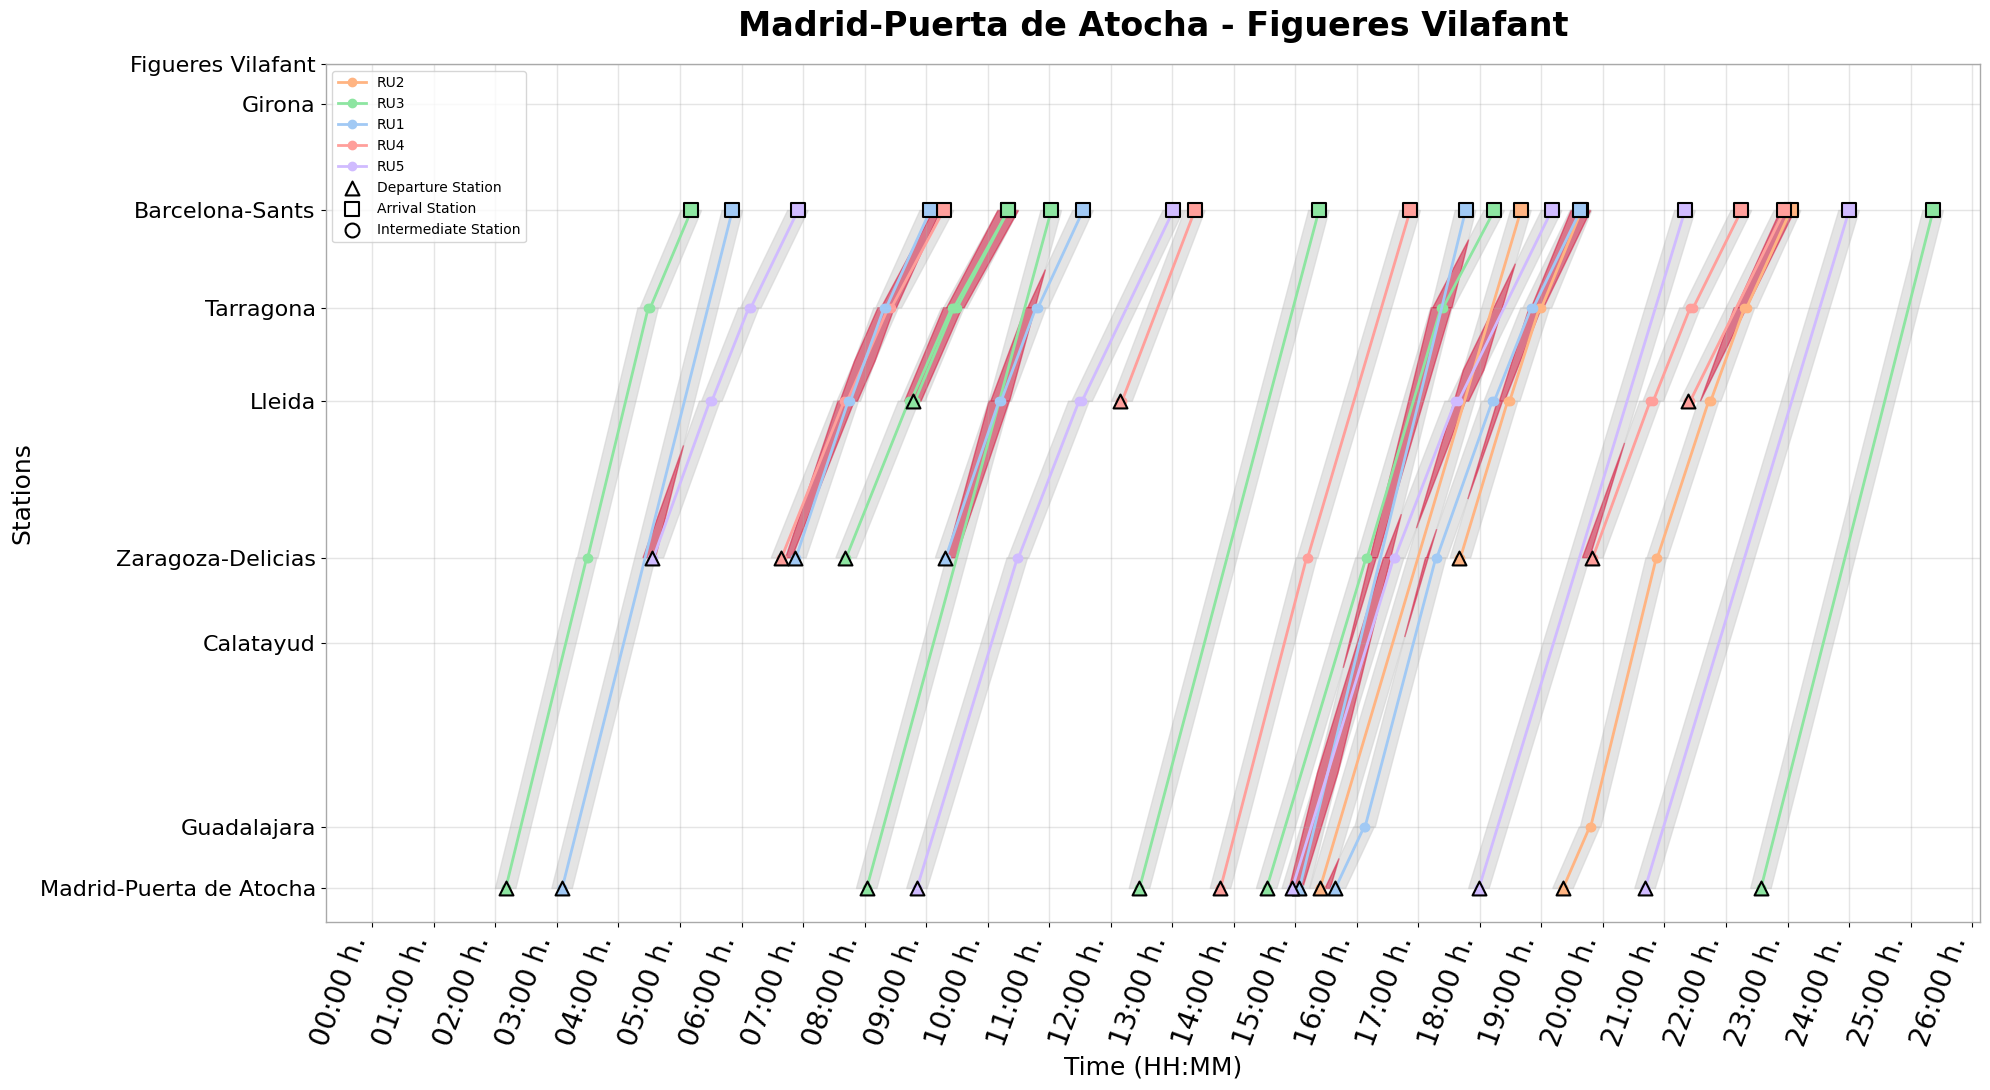

In [6]:
date = datetime.datetime.strptime('2025-06-25', '%Y-%m-%d').date()
plot_marey_chart(
    supply=supply,
    date=date,
    save_path='../figures/escim2025/'
)

## 1. Pyomo

In [7]:
mptt = MPTT(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=SAFETY_GAP
)

In [8]:
departure_times = {}
travel_times = {}
dwell_times = {}
lower_bounds = {}
upper_bounds = {}
for service in supply.services:
    for i, (station, (arrival, departure)) in enumerate(service.schedule.items()):
        if len(service.schedule) > 1 and i == len(service.schedule) - 1:
            break
        service_stations_dict = {station.id: station for station in service.line.stations}
        station = service_stations_dict[station]
        departure_times[(service.id, station.id)] = departure.total_seconds() // 60
        travel_times[(service.id, station.id)] = (tuple(service.schedule.values())[i+1][0] - departure).total_seconds() / 60
        dwell_times[(service.id, station.id)] = (departure - arrival).total_seconds() / 60
        # Equation 2
        lower_bounds[(service.id, station.id)] = departure.total_seconds() // 60 - 60
        upper_bounds[(service.id, station.id)] = departure.total_seconds() // 60 + 60

In [9]:
def bounds_schedule_times(model, service, station):
    return (lower_bounds[(service, station)], upper_bounds[(service, station)])

In [10]:
scheduler = ServiceScheduler(supply.services)

In [11]:
services_segments = list(scheduler.segments.values())

segments = [segment for service_segments in services_segments for segment in service_segments]
print(len(segments))

segments_combinations = [((segment1.service_id, segment1), (segment2.service_id, segment2)) for segment1, segment2 in itertools.product(segments, segments)]
segments_combinations = list(filter(lambda x: x[0][0] != x[1][0], segments_combinations))

print(len(segments_combinations))

57
3082


In [12]:
IM_BOUND = 60
MAX_DWELL_TIME = 10

services = {service.id: service for service in supply.services}

model = pyo.ConcreteModel()

service_station_idx = list(travel_times.keys())
services_names = list(dict.fromkeys(mptt.service_indexer))

model.requests = pyo.Set(initialize=service_station_idx, dimen=2)
model.segments = pyo.Set(initialize=segments_combinations, dimen=4)

model.schedule_times = pyo.Var(model.requests, within=pyo.NonNegativeReals, bounds=bounds_schedule_times)
model.is_scheduled = pyo.Var(services_names, within=pyo.Binary)

model.departure_times = pyo.Param(model.requests, initialize=departure_times, within=pyo.NonNegativeReals)
model.travel_times = pyo.Param(model.requests, initialize=travel_times, within=pyo.NonNegativeReals)
model.dwell_times = pyo.Param(model.requests, initialize=dwell_times, within=pyo.NonNegativeReals)


def penalty_function(x: float, k: float) -> float:
    """
    Calculate the penalty function based on the given parameters.

    Args:
        x (float): Normalized deviation from the ideal schedule time.
        k (float): Penalty factor that influences the steepness of the penalty curve.

    Returns:
        float: The penalty value calculated using the formula.
    """
    return 1 - e ** (-k * x ** 2) * (0.5 * pyo.cos(pi * x) + 0.5)


def departure_time_penalty(model: pyo.ConcreteModel, service: str, im_bound: int = IM_BOUND) -> float:
    """
    Calculate the penalty for the departure time of a service.

    Args:
        model (pyo.ConcreteModel): Pyomo model containing the schedule times.
        service (str): Service ID for which the penalty is calculated.
        im_bound (int): Maximum allowed deviation in minutes (default is 60).

    Returns:
        float: Penalty value based on the departure time deviation.
    """
    first_station_id = services[service].line.stations[0].id
    alpha = penalty_function(
        x = abs(model.schedule_times[(service, first_station_id)] - list(mptt.requested_schedule[service].values())[0][1]) / im_bound,
        k = revenue_behavior[service]['k']
    )
    return alpha * revenue_behavior[service]['dt_max_penalty']

def travel_time_penalty(model: pyo.ConcreteModel, service: str, im_bound: int = IM_BOUND) -> float:
    """
    Calculate the penalty for the travel time of a service.

    Args:
        model (pyo.ConcreteModel): Pyomo model containing the schedule times.
        service (str): Service ID for which the penalty is calculated.
        im_bound (int): Maximum allowed deviation in minutes (default is 60).

    Returns:
        float: Penalty value based on the travel time deviation.
    """
    total_travel_time_penalty = 0.0
    for j in range(len(mptt.requested_schedule[service]) - 2):
        next_station_id = list(mptt.requested_schedule[service].keys())[j + 1]
        station_id = list(mptt.requested_schedule[service].keys())[j]
        updated_travel_time = model.schedule_times[(service, next_station_id)] - model.schedule_times[(service, station_id)] - model.dwell_times[(service, station_id)]
        beta = penalty_function(
            x=abs(updated_travel_time - model.travel_times[(service, station_id)]) / im_bound,
            k=revenue_behavior[service]['k']
        )
        total_travel_time_penalty += beta * revenue_behavior[service]['tt_max_penalty']
    return total_travel_time_penalty

# Equation 1
@model.Objective(sense=pyo.maximize)
def objective_function(model: pyo.ConcreteModel):
    """
    Objective function to maximize the total revenue from scheduled services.

    Args:
        model (pyo.ConcreteModel): Pyomo model containing the scheduled services and their penalties.

    Returns:
        float: Total revenue adjusted by penalties for each scheduled service.
    """
    return sum(
        model.is_scheduled[service_id] * (revenue_behavior[service_id]['canon'] - departure_time_penalty(model, service_id) - travel_time_penalty(model, service_id))
        for service_id in services_names
    )

# Equation 3
def departure_time_rule(model: pyo.ConcreteModel, service: str, station_id: str) -> bool:
    """
    Check the departure time of a service in next station is after the previous station's departure time plus travel and dwell times.
    Returns True if the condition is met, False otherwise.

    Args:
        model (pyo.ConcreteModel): Pyomo model containing the schedule times and travel/dwell times.
        service (str): Service ID for which the constraint is applied.
        j (int): Index of the station in the service schedule.

    Returns:
        pyo.Constraint: Constraint ensuring the departure time condition is met.
    """
    first_station_id = list(mptt.requested_schedule[service].keys())[0]
    if station_id == first_station_id:
        return pyo.Constraint.Skip
    station_id_idx = list(mptt.requested_schedule[service].keys()).index(station_id)
    previous_station_id = list(mptt.requested_schedule[service].keys())[station_id_idx - 1]
    return (
        model.schedule_times[(service, station_id)] * model.is_scheduled[service]
        >= (model.schedule_times[(service, previous_station_id)]
           + model.travel_times[(service, previous_station_id)]
           + model.dwell_times[(service, station_id)]) * model.is_scheduled[service]
    )

model.departure_time_restriction = pyo.Constraint(model.requests, rule=departure_time_rule)

# Equation 4
def dwell_time_arrival_rule(model, service, station_id, max_dwell_time=MAX_DWELL_TIME) -> bool:
    """
    Ensure that the schedule time at the arrival station is less than or equal to the departure time plus maximum dwell time.

    Args:
        model (pyo.ConcreteModel): Pyomo model containing the schedule times and is_scheduled variables.
        service (str): Service ID for which the constraint is applied.
        j (int): Index of the station in the service schedule.
        max_dwell_time (int): Maximum allowed dwell time in minutes (default is 10).

    Returns:
        bool: Constraint ensuring the schedule time at the arrival station is within the allowed limits.
    """
    first_station_id = list(mptt.requested_schedule[service].keys())[0]
    if station_id == first_station_id:
        return pyo.Constraint.Skip
    return (
        model.schedule_times[(service, station_id)] * model.is_scheduled[service]
        <= (model.departure_times[(service, station_id)] + max_dwell_time)
          * model.is_scheduled[service]
    )

# Equation 4
def dwell_time_prev_rule(model, service, station_id, max_dwell_time=MAX_DWELL_TIME) -> bool:
    """
    Ensure that the schedule time at the current station is less than or equal to the previous station's schedule time plus travel time and maximum dwell time.

    Args:
        model (pyo.ConcreteModel): Pyomo model containing the schedule times and is_scheduled variables.
        service (str): Service ID for which the constraint is applied.
        j (int): Index of the station in the service schedule.
        max_dwell_time (int): Maximum allowed dwell time in minutes (default is 10).

    Returns:
        bool: Constraint ensuring the schedule time at the current station is within the allowed limits.
    """
    first_station_id = list(mptt.requested_schedule[service].keys())[0]
    if station_id == first_station_id:
        return pyo.Constraint.Skip
    station_id_idx = list(mptt.requested_schedule[service].keys()).index(station_id)
    previous_station_id = list(mptt.requested_schedule[service].keys())[station_id_idx - 1]
    return (
        model.schedule_times[(service, station_id)] * model.is_scheduled[service]
        <= (model.schedule_times[(service, previous_station_id)]
            + model.travel_times[(service, previous_station_id)]
            + max_dwell_time
          ) * model.is_scheduled[service]
    )

model.dwell_time_arrival = pyo.Constraint(model.requests, rule=dwell_time_arrival_rule)
model.dwell_time_prev    = pyo.Constraint(model.requests, rule=dwell_time_prev_rule)

# Equation 6
def conflicts_rule(model, service1, segment1, service2, segment2):
    common_edges = set(segment1.edges) & set(segment2.edges)
    if not common_edges:
        return pyo.Constraint.Skip
    # For each overlapping edge, compare start and end times
    for (origin_station, destination_station) in common_edges:
        # Time when each enters and exits the edge
        t1_start, t1_end = segment1.time_at(origin_station), segment1.time_at(destination_station)
        t2_start, t2_end = segment2.time_at(origin_station), segment2.time_at(destination_station)
        diff_start = (t2_start - t1_start).total_seconds() / 60
        diff_end = (t2_end - t1_end).total_seconds() / 60
        # Conflict if different order or gaps below double headway
        double_headway = 2 * 10
        is_conflict = diff_start * diff_end <= 0 or abs(diff_start) <= double_headway or abs(diff_end) <= double_headway
        if is_conflict:
            return model.is_scheduled[service1] * model.is_scheduled[service2] == 0
        else:
            pyo.Constraint.Skip
    return pyo.Constraint.Skip

model.conflicts = pyo.Constraint(model.segments, rule=conflicts_rule)

In [13]:
solver = pyo.SolverFactory('scip')
solver.options['limits/time'] = 30
result_obj = solver.solve(model, tee=True)

SCIP version 9.2.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 7.1.3] [GitHash: 416226a4f8]
Copyright (c) 2002-2025 Zuse Institute Berlin (ZIB)

External libraries: 
  Readline 8.2         GNU library for command line editing (gnu.org/s/readline)
  SoPlex 7.1.3         Linear programming solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 60fd96f2]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.2.12          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.3.0            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.4.1         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) (built with TBB)
  Nauty 2.8.8          Computing Graph Automorphism Groups by Brendan D. McKay (users.cecs.an

In [14]:
model.is_scheduled.display()

is_scheduled : Size=25, Index={0_2025-06-25-17.40, 1_2025-06-25-14.32, 2_2025-06-25-15.04, 3_2025-06-25-13.47, 4_2025-06-25-22.34, 5_2025-06-25-12.09, 6_2025-06-25-2.10, 7_2025-06-25-8.02, 8_2025-06-25-8.51, 9_2025-06-25-15.24, 10_2025-06-25-12.28, 11_2025-06-25-3.05, 12_2025-06-25-6.38, 13_2025-06-25-15.39, 14_2025-06-25-19.21, 15_2025-06-25-6.52, 16_2025-06-25-4.33, 17_2025-06-25-8.47, 18_2025-06-25-17.59, 19_2025-06-25-19.49, 20_2025-06-25-9.18, 21_2025-06-25-20.41, 22_2025-06-25-7.41, 23_2025-06-25-21.23, 24_2025-06-25-14.57}
    Key                 : Lower : Value : Upper : Fixed : Stale : Domain
     0_2025-06-25-17.40 :     0 :   0.0 :     1 : False : False : Binary
    10_2025-06-25-12.28 :     0 :   1.0 :     1 : False : False : Binary
     11_2025-06-25-3.05 :     0 :   0.0 :     1 : False : False : Binary
     12_2025-06-25-6.38 :     0 :   0.0 :     1 : False : False : Binary
    13_2025-06-25-15.39 :     0 :   1.0 :     1 : False : False : Binary
    14_2025-06-25-19.21 : 

In [15]:
model.schedule_times.display()

schedule_times : Size=57, Index=requests
    Key                                    : Lower  : Value              : Upper  : Fixed : Stale : Domain
          ('0_2025-06-25-17.40', 'Lleida') : 1049.0 :             1049.0 : 1169.0 : False : False : NonNegativeReals
       ('0_2025-06-25-17.40', 'Tarragona') : 1080.0 :             1080.0 : 1200.0 : False : False : NonNegativeReals
        ('0_2025-06-25-17.40', 'Zaragoza') : 1001.0 :             1001.0 : 1121.0 : False : False : NonNegativeReals
         ('10_2025-06-25-12.28', 'Madrid') :  688.0 :              748.0 :  808.0 : False : False : NonNegativeReals
          ('11_2025-06-25-3.05', 'Madrid') :  125.0 :              125.0 :  245.0 : False : False : NonNegativeReals
          ('12_2025-06-25-6.38', 'Lleida') :  403.0 :              403.0 :  523.0 : False : False : NonNegativeReals
       ('12_2025-06-25-6.38', 'Tarragona') :  446.0 :              446.0 :  566.0 : False : False : NonNegativeReals
        ('12_2025-06-25-6.38', 'Z

In [16]:
pyo.value(model.objective_function)

4257.586031691052

In [17]:
max_revenue = sum([mptt.revenue[service]['canon'] for service in mptt.revenue])
max_revenue

5824.5

In [18]:
real_solution = np.array([pyo.value(model.schedule_times[(service, j)]) for service, j in model.requests], dtype=float)
discrete_solution = np.array([bool(int(pyo.value(Bi))) for Bi in model.is_scheduled.values()], dtype=bool)

mptt.get_revenue(Solution(real=real_solution, discrete=discrete_solution))

4259.75

In [19]:
updated_supply_path = f'../data/generator/supply_updated.yml'

# Modify services with the new schedule times (only scheduled services are included)
updated_services = mptt.update_supply(path=generator_save_path, solution=Solution(real=real_solution, discrete=discrete_solution))

# Save the updated supply to a YAML file
supply_saver = SupplySaver(services=updated_services)
supply_saver.to_yaml(updated_supply_path)

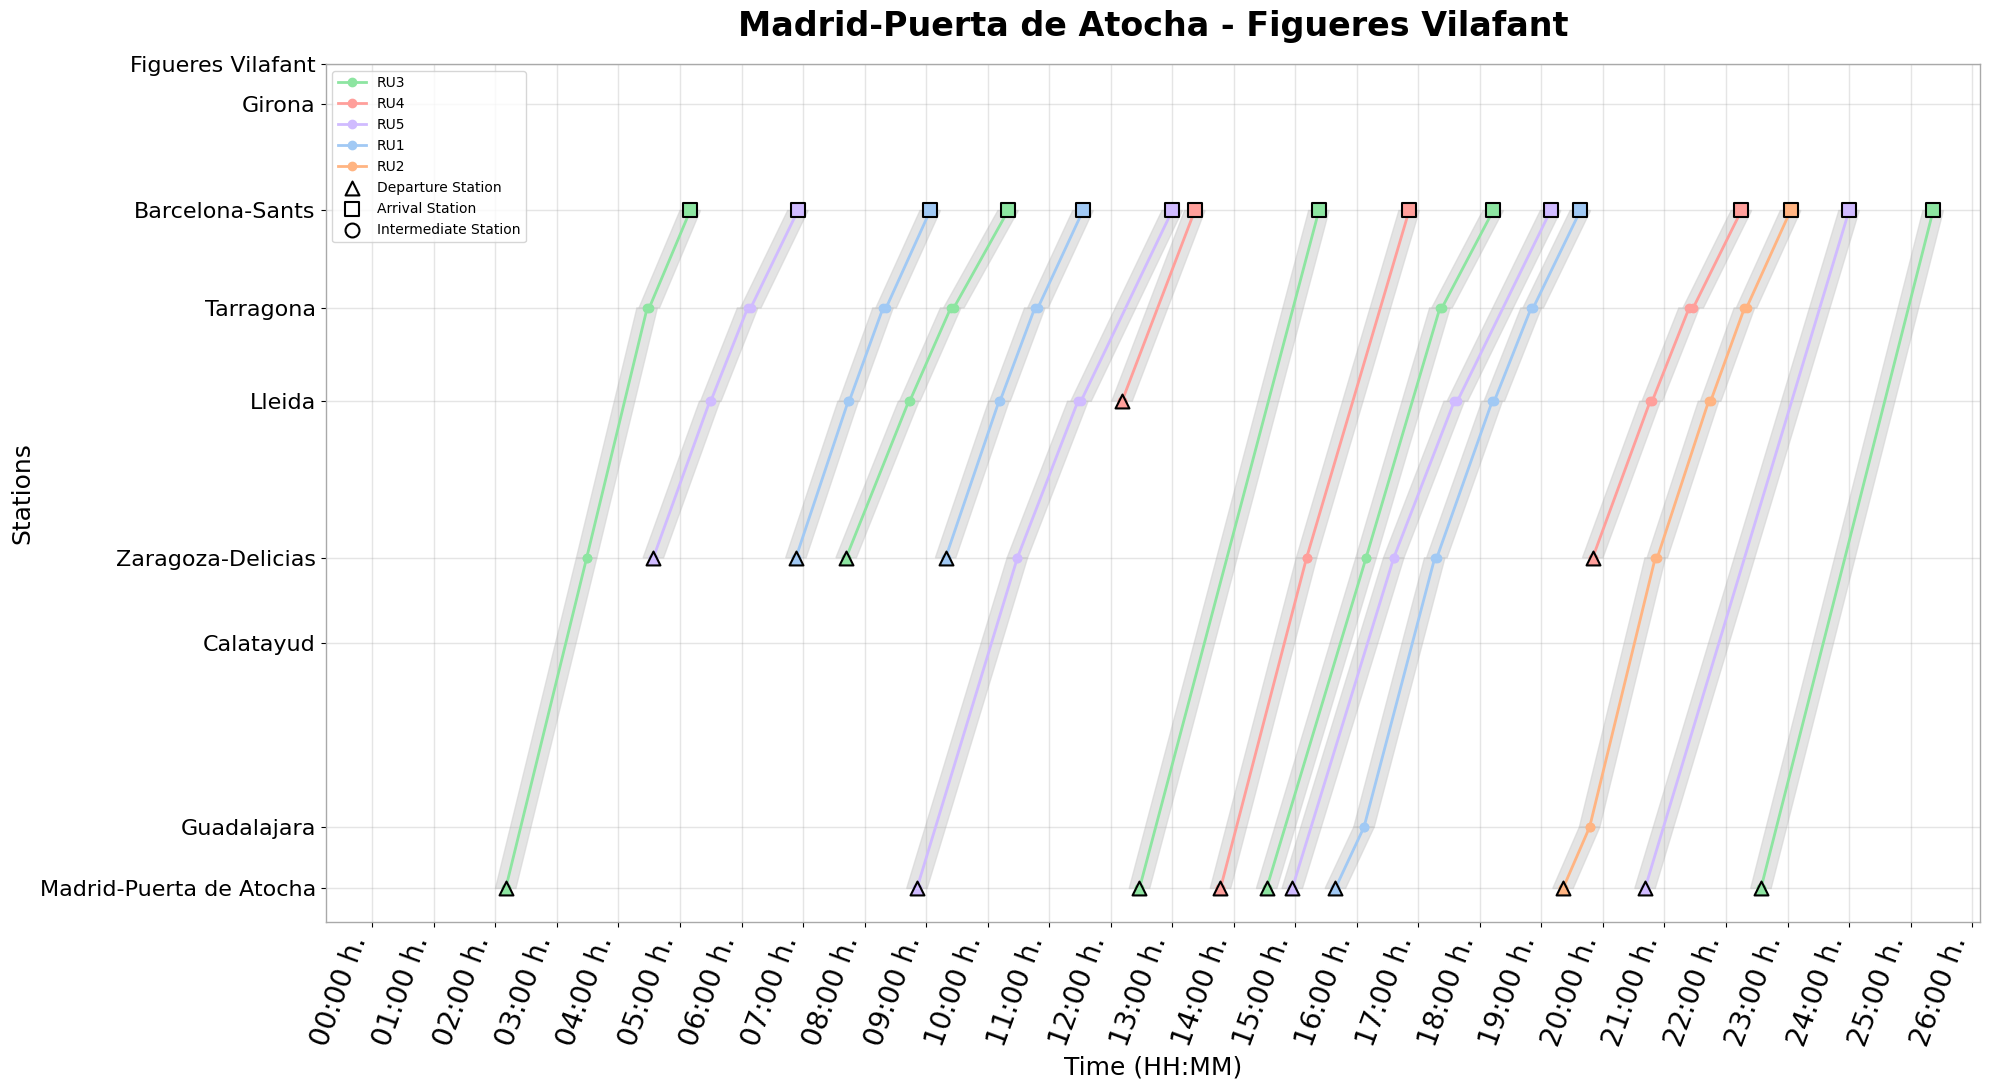

In [20]:
date = datetime.datetime.strptime('2025-06-25', '%Y-%m-%d').date()

updated_supply = Supply.from_yaml(updated_supply_path)

plot_marey_chart(
    supply=updated_supply,
    date=date,
    save_path='../figures/escim2025/'
)